In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV3Small, DenseNet121,VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from datetime import datetime
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility

tf.random.set_seed(42)
np.random.seed(42)

In [3]:
##### CONFIGURATION SETTINGS

IMG_SIZE = (224, 224)        # Standard input size for most pre-trained models
BATCH_SIZE = 32              # Batch size for training
EPOCHS = 35                  # Number of initial training epochs
NUM_CLASSES = 7              # Number of disease classes
DATA_PATH = "Data segrigation"  

In [4]:
# Create directories for saving models and history

os.makedirs('saved_models', exist_ok=True)
os.makedirs('training_history', exist_ok=True)

In [5]:
# Disease class names from dataset

CLASS_NAMES = [
    'Bacteria Blight',
    'Brown spot', 
    'Caterpillar Damage',
    'Dry',
    'Kanamadiri haniya',
    'Leaf spot',
    'Red Spider mite Damage'
]

In [6]:
##### DATA PREPARATION AND CLASS IMBALANCE HANDLING

In [7]:
def prepare_data():
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    # Iterate through each disease class folder
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(DATA_PATH, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(class_idx)
    
    # Convert to numpy arrays for easier manipulation
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Print dataset statistics
    print("=" * 60)
    print("DATASET STATISTICS")
    print("=" * 60)
    print(f"Total images: {len(image_paths)}")
    print("\nClass distribution:")
    for i, class_name in enumerate(CLASS_NAMES):
        count = np.sum(labels == i)
        print(f"  {class_name}: {count} images")
    
    # Split data: 80% train, 10% validation, 10% test with stratification
    
    # First split: separate 80% for training
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, 
        test_size=0.2,           # 20% for temp (split into val and test)
        random_state=42, 
        stratify=labels          # Maintain class distribution in splits
    )
    
    # Second split: split temp into 50% validation and 50% test (10% each of total)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=0.5,           # Split temp equally into val and test
        random_state=42, 
        stratify=y_temp
    )
    
    # Print split information
    print("\n" + "=" * 60)
    print("DATA SPLIT INFORMATION")
    print("=" * 60)
    print(f"Training set: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [8]:
# Prepare the data using the function above

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data()

DATASET STATISTICS
Total images: 3227

Class distribution:
  Bacteria Blight: 67 images
  Brown spot: 738 images
  Caterpillar Damage: 75 images
  Dry: 250 images
  Kanamadiri haniya: 39 images
  Leaf spot: 1971 images
  Red Spider mite Damage: 87 images

DATA SPLIT INFORMATION
Training set: 2581 images (80.0%)
Validation set: 323 images (10.0%)
Test set: 323 images (10.0%)


In [9]:
# Calculate class weights to handle imbalance during training
# This gives higher weight to minority classes during loss calculation

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n" + "=" * 60)
print("CLASS WEIGHTS FOR IMBALANCE HANDLING")
print("=" * 60)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {class_weight_dict[i]:.2f} (higher = more emphasis)")


CLASS WEIGHTS FOR IMBALANCE HANDLING
  Bacteria Blight: 6.83 (higher = more emphasis)
  Brown spot: 0.62 (higher = more emphasis)
  Caterpillar Damage: 6.15 (higher = more emphasis)
  Dry: 1.84 (higher = more emphasis)
  Kanamadiri haniya: 11.89 (higher = more emphasis)
  Leaf spot: 0.23 (higher = more emphasis)
  Red Spider mite Damage: 5.27 (higher = more emphasis)


In [10]:
##### DATA AUGMENTATION AND TENSORFLOW DATASET CREATION

In [11]:
def load_and_preprocess_image(path, label):
    
    # Read and decode image
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    
    # Resize to target size
    image = tf.image.resize(image, IMG_SIZE)
    
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

In [12]:
def create_tf_dataset(image_paths, labels, batch_size=32, shuffle=False, augmentation=False):
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Load and preprocess images
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply augmentation 
    if augmentation:
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_up_down(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: (tf.image.random_brightness(x, 0.2), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Shuffle 
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [13]:
# Create datasets with augmentation for training

print("\n" + "=" * 60)
print("CREATING TENSORFLOW DATASETS")
print("=" * 60)
train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE, shuffle=True, augmentation=True)
val_dataset = create_tf_dataset(X_val, y_val, BATCH_SIZE)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE)

print("Datasets created successfully!")
print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")


CREATING TENSORFLOW DATASETS
Datasets created successfully!
Training batches: 81
Validation batches: 11
Test batches: 11


In [14]:
#### HISTORY MANAGEMENT FUNCTIONS

In [14]:
def save_training_history(history, model_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_filename = f'training_history/{model_name}_history_{timestamp}.pkl'
    
    # Convert history to serializable format
    history_dict = {}
    for key, values in history.history.items():
        history_dict[key] = [float(value) for value in values]
    
    with open(history_filename, 'wb') as f:
        pickle.dump(history_dict, f)
    
    print(f"Training history saved to {history_filename}")
    return history_dict

def load_training_history(model_name):
    """Load the most recent training history for a model"""
    history_files = [f for f in os.listdir('training_history') if f.startswith(f'{model_name}_history')]
    if not history_files:
        return None
    
    # Get the most recent file
    latest_file = sorted(history_files)[-1]
    with open(f'training_history/{latest_file}', 'rb') as f:
        history_dict = pickle.load(f)
    
    # Convert back to History object format
    class SimpleHistory:
        def __init__(self, history_dict):
            self.history = history_dict
    
    return SimpleHistory(history_dict)

In [16]:
##### MODEL CREATION FUNCTIONS

In [17]:
## Model 1- ResNet 50

In [18]:
def create_resnet50_model():
   
    # Load pre-trained ResNet50 without top classification layer
    base_model = ResNet50(
        weights='imagenet',          # Use ImageNet pre-trained weights
        include_top=False,           # Exclude final classification layer
        input_shape=(224, 224, 3)    # Input image shape
    )
    
    # Freeze base model initially for transfer learning
    base_model.trainable = False
    
    # Build custom classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
    x = BatchNormalization()(x)      # Stabilize training
    x = Dropout(0.3)(x)              # Prevent overfitting
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Final classification layer
    
    model = Model(inputs, outputs)
    
    # Compile with custom optimizer settings
    optimizer = Adam(learning_rate=0.001)  # Standard learning rate for ResNet
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
        metrics=['accuracy']
    )
    
    return model, base_model

In [19]:
## Model 2- MobileNet V3

In [20]:
def create_mobilenetv3_model():
    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)  # Smaller dense layer for mobile network
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # MobileNetV3 with slightly higher learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [21]:
## Model 3- DenseNet 121

In [22]:
def create_densenet121_model():
    
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)  # Higher dropout for DenseNet
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [23]:
## Model 4- GoogleNet-InceptionV3

In [24]:
def create_googlenet_model():
    
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [17]:
## Model 5- ConvNeXt Small

In [15]:
def create_convnext_model():
    base_model = ConvNeXtSmall(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [27]:
## Model 6- VGG 16

In [16]:
def create_vgg16_model():
    # Load pre-trained VGG16 without top classification layer
    base_model = VGG16(
        weights='imagenet',          # Use ImageNet pre-trained weights
        include_top=False,           # Exclude final classification layer
        input_shape=(224, 224, 3)    # Input image shape
    )
    
    # Freeze base model initially for transfer learning
    base_model.trainable = False
    
    # Build custom classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
    x = BatchNormalization()(x)      # Stabilize training
    x = Dropout(0.5)(x)              # Higher dropout for VGG (more parameters)
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Final classification layer
    
    model = Model(inputs, outputs)
    
    # Compile with custom optimizer settings
    optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for VGG
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [29]:
#### MODEL TRAINING AND EVALUATION

In [18]:
all_models_results = {}

def print_model_results(model_name, history, history_fine, test_loss, test_accuracy):
    
    print(f"\n" + "="*70)
    print(f"{model_name} - FINAL RESULTS")
    print("="*70)
    
    # Get final training metrics
    if history_fine:
        # If fine-tuning was done, use the fine-tuned history
        final_train_accuracy = history_fine.history['accuracy'][-1]
        final_train_loss = history_fine.history['loss'][-1]
        final_val_accuracy = history_fine.history['val_accuracy'][-1]
        final_val_loss = history_fine.history['val_loss'][-1]
    else:
        # If no fine-tuning, use the initial training history
        final_train_accuracy = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_val_loss = history.history['val_loss'][-1]
    
    # Print training results
    print("TRAINING PHASE:")
    print(f"   Final Training Accuracy:   {final_train_accuracy:.4f}")
    print(f"   Final Training Loss:       {final_train_loss:.4f}")
    print(f"   Final Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"   Final Validation Loss:     {final_val_loss:.4f}")
    
    # Print test results
    print("\nTEST PHASE:")
    print(f"   Test Accuracy:             {test_accuracy:.4f}")
    print(f"   Test Loss:                 {test_loss:.4f}")
    
    # Calculate improvement/drop from validation to test
    accuracy_drop = final_val_accuracy - test_accuracy
    loss_increase = test_loss - final_val_loss
    
    print(f"\nPERFORMANCE SUMMARY:")
    print(f"   Accuracy Drop (Val -> Test): {accuracy_drop:+.4f}")
    print(f"   Loss Increase (Val -> Test): {loss_increase:+.4f}")
    
    if accuracy_drop <= 0.05 and loss_increase <= 0.1:
        print("   Good generalization - model is not overfitting significantly")
    else:
        print("   Potential overfitting - consider more regularization")

In [19]:
def plot_training_history(history, history_fine, model_name):
   
    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
        
        initial_epochs = len(history.history['accuracy'])
        total_epochs = initial_epochs + len(history_fine.history['accuracy'])
        epochs_range = range(total_epochs)
        fine_tune_start = initial_epochs
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))
        fine_tune_start = None
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    if fine_tune_start:
        ax1.axvline(fine_tune_start - 0.5, color='gray', linestyle='--', 
                   label='Fine-tuning Start')
    ax1.set_title(f'{model_name} - Training & Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    if fine_tune_start:
        ax2.axvline(fine_tune_start - 0.5, color='gray', linestyle='--', 
                   label='Fine-tuning Start')
    ax2.set_title(f'{model_name} - Training & Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [32]:
##### COMPLETE TRAINING AND EVALUATION

In [33]:
## Train- RESNET50


1. TRAINING AND EVALUATING RESNET50
ResNet50 model created successfully!
   Total parameters: 24,650,631

Phase 1: Training ResNet50 with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2923 - loss: 2.6012
Epoch 1: val_accuracy improved from None to 0.21429, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.3656 - loss: 2.1812 - val_accuracy: 0.2143 - val_loss: 1.6278 - learning_rate: 0.0010
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4881 - loss: 1.4634
Epoch 2: val_accuracy did not improve from 0.21429
81/81 ━━━━━━━━━━━━━━━━━━━━ 464s 5s/step - accuracy: 0.4973 - loss: 1.4095 - val_accuracy: 0.0311 - val_loss: 1.8415 - learning_rate: 0.0010
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5659 - loss: 1.0428
Epoch 3: val_accuracy improved from 0.21429 to 0.59006, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.5730 - loss: 1.0617 - val_accuracy: 0.5901 - val_loss: 1.2854 - learning_rate: 0.0010
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6168 - loss: 1.0109
Epoch 4: val_accuracy improved from 0.59006 to 0.72050, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 395s 5s/step - accuracy: 0.6154 - loss: 0.9582 - val_accuracy: 0.7205 - val_loss: 1.1223 - learning_rate: 0.0010
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6594 - loss: 0.8940
Epoch 5: val_accuracy improved from 0.72050 to 0.74845, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.6546 - loss: 0.8660 - val_accuracy: 0.7484 - val_loss: 0.7851 - learning_rate: 0.0010
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6643 - loss: 0.8180
Epoch 6: val_accuracy improved from 0.74845 to 0.76087, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.6772 - loss: 0.7733 - val_accuracy: 0.7609 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6963 - loss: 0.7818
Epoch 7: val_accuracy improved from 0.76087 to 0.80745, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.7028 - loss: 0.7865 - val_accuracy: 0.8075 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 8/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7217 - loss: 0.6976
Epoch 8: val_accuracy improved from 0.80745 to 0.81056, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.7191 - loss: 0.7284 - val_accuracy: 0.8106 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 9/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7468 - loss: 0.6853
Epoch 9: val_accuracy did not improve from 0.81056
81/81 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.7409 - loss: 0.7095 - val_accuracy: 0.7919 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 10/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7419 - loss: 0.6680
Epoch 10: val_accuracy did not improve from 0.81056
81/81 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - accuracy: 0.7514 - loss: 0.6190 - val_accuracy: 0.8012 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 11/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7647 - loss: 0.5825
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_accuracy did not improve from 0.81056
81/81 ━━━━━━━━━━━━━━━━━━━━ 386s 5s/step - accuracy: 0.7630 - loss: 0.5749 - val_accuracy: 0.7733

81/81 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.7879 - loss: 0.4733 - val_accuracy: 0.8292 - val_loss: 0.4935 - learning_rate: 5.0000e-04
Epoch 15/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7928 - loss: 0.4284
Epoch 15: val_accuracy did not improve from 0.82919
81/81 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.7898 - loss: 0.4206 - val_accuracy: 0.8292 - val_loss: 0.4653 - learning_rate: 5.0000e-04
Epoch 16/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8068 - loss: 0.3978
Epoch 16: val_accuracy improved from 0.82919 to 0.84472, saving model to saved_models/best_ResNet50.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8186 - loss: 0.4008 - val_accuracy: 0.8447 - val_loss: 0.4739 - learning_rate: 5.0000e-04
Epoch 17/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7910 - loss: 0.4349
Epoch 17: val_accuracy did not improve from 0.84472
81/81 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7984 - loss: 0.4700 - val_accuracy: 0.8261 - val_loss: 0.4689 - learning_rate: 5.0000e-04
Epoch 18/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8138 - loss: 0.4195
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: val_accuracy did not improve from 0.84472
81/81 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.8096 - loss: 0.4479 - val_accuracy: 0.8106 - val_loss: 0.4965 - learning_rate: 5.0000e-04
Epoch 19/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8189 - loss: 0.3517
Epoch 19: val_accuracy did not improve from 0.84472
81/81 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.8116 - loss: 0.3951 - val_ac

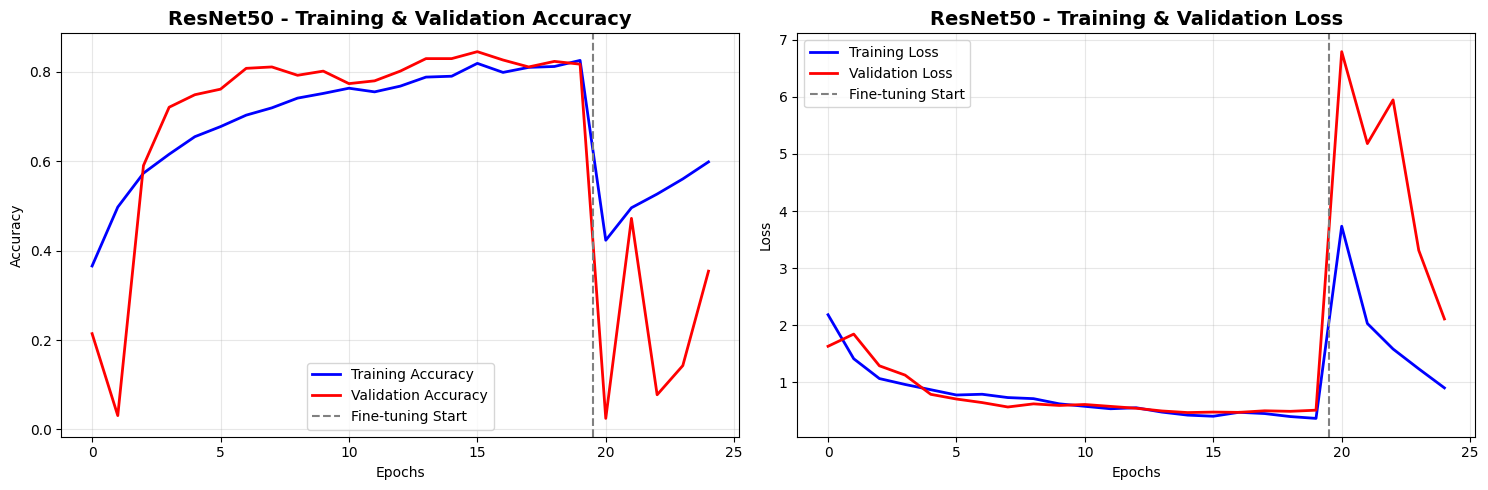


Evaluating ResNet50 on test set...



ResNet50 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.5983
   Final Training Loss:       0.8981
   Final Validation Accuracy: 0.3540
   Final Validation Loss:     2.1071

TEST PHASE:
   Test Accuracy:             0.0217
   Test Loss:                 6.7707

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.3323
   Loss Increase (Val -> Test): +4.6636
   Potential overfitting - consider more regularization
ResNet50 model saved as 'saved_models/ResNet50_betel_disease.h5'


In [34]:
print("\n" + "="*80)
print("1. TRAINING AND EVALUATING RESNET50")
print("="*80)

# Create ResNet50 model
resnet_model, resnet_base = create_resnet50_model()
print("ResNet50 model created successfully!")
print(f"   Total parameters: {resnet_model.count_params():,}")

# Define callbacks
resnet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_ResNet50.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training ResNet50 with frozen base model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(resnet_history, "ResNet50_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning ResNet50...")
resnet_base.trainable = True
fine_tune_at = len(resnet_base.layers) // 2

for layer in resnet_base.layers[:fine_tune_at]:
    layer.trainable = False

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

resnet_history_fine = resnet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=resnet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(resnet_history_fine, "ResNet50_phase2")

# Plot training history
plot_training_history(resnet_history, resnet_history_fine, "ResNet50")

# Evaluate on test set
print("\nEvaluating ResNet50 on test set...")
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("ResNet50", resnet_history, resnet_history_fine, resnet_test_loss, resnet_test_accuracy)

# Store results
all_models_results["ResNet50"] = {
    'train_accuracy': resnet_history_fine.history['accuracy'][-1],
    'train_loss': resnet_history_fine.history['loss'][-1],
    'val_accuracy': resnet_history_fine.history['val_accuracy'][-1],
    'val_loss': resnet_history_fine.history['val_loss'][-1],
    'test_accuracy': resnet_test_accuracy,
    'test_loss': resnet_test_loss
}

# Save model
resnet_model.save('saved_models/ResNet50_betel_disease.h5')
print("ResNet50 model saved as 'saved_models/ResNet50_betel_disease.h5'")

In [35]:
## Train - MobileNet V3


5. TRAINING AND EVALUATING MOBILENET V3
MobileNetV3 model created successfully!
   Total parameters: 1,016,695

Phase 1: Training MobileNetV3 with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.2661 - loss: 2.1479
Epoch 1: val_accuracy improved from None to 0.02484, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 718ms/step - accuracy: 0.3108 - loss: 1.7920 - val_accuracy: 0.0248 - val_loss: 2.3554 - learning_rate: 0.0010
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.4206 - loss: 1.5018
Epoch 2: val_accuracy did not improve from 0.02484
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 619ms/step - accuracy: 0.4623 - loss: 1.3497 - val_accuracy: 0.0248 - val_loss: 2.5381 - learning_rate: 0.0010
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5356 - loss: 1.1962
Epoch 3: val_accuracy improved from 0.02484 to 0.03416, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 85s 643ms/step - accuracy: 0.5423 - loss: 1.1796 - val_accuracy: 0.0342 - val_loss: 2.8612 - learning_rate: 0.0010
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5526 - loss: 1.0137
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy improved from 0.03416 to 0.15839, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 87s 698ms/step - accuracy: 0.5536 - loss: 1.1215 - val_accuracy: 0.1584 - val_loss: 2.6622 - learning_rate: 0.0010
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5415 - loss: 1.0385
Epoch 5: val_accuracy improved from 0.15839 to 0.18323, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 694ms/step - accuracy: 0.5462 - loss: 1.0554 - val_accuracy: 0.1832 - val_loss: 2.3152 - learning_rate: 5.0000e-04
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6298 - loss: 0.8855
Epoch 6: val_accuracy improved from 0.18323 to 0.24534, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 692ms/step - accuracy: 0.6255 - loss: 0.9963 - val_accuracy: 0.2453 - val_loss: 1.9732 - learning_rate: 5.0000e-04
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6010 - loss: 0.9545
Epoch 7: val_accuracy improved from 0.24534 to 0.36025, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 710ms/step - accuracy: 0.5800 - loss: 1.0130 - val_accuracy: 0.3602 - val_loss: 1.5637 - learning_rate: 5.0000e-04
Epoch 8/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.5927 - loss: 0.9197
Epoch 8: val_accuracy improved from 0.36025 to 0.58075, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 648ms/step - accuracy: 0.6022 - loss: 0.9366 - val_accuracy: 0.5807 - val_loss: 1.0522 - learning_rate: 5.0000e-04
Epoch 9/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6441 - loss: 0.7815
Epoch 9: val_accuracy did not improve from 0.58075
81/81 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step - accuracy: 0.6434 - loss: 0.8991 - val_accuracy: 0.5683 - val_loss: 0.9688 - learning_rate: 5.0000e-04
Epoch 10/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6294 - loss: 0.7969
Epoch 10: val_accuracy improved from 0.58075 to 0.72050, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 696ms/step - accuracy: 0.6251 - loss: 0.8747 - val_accuracy: 0.7205 - val_loss: 0.7312 - learning_rate: 5.0000e-04
Epoch 11/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6379 - loss: 0.8646
Epoch 11: val_accuracy improved from 0.72050 to 0.74534, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 700ms/step - accuracy: 0.6204 - loss: 0.8637 - val_accuracy: 0.7453 - val_loss: 0.6954 - learning_rate: 5.0000e-04
Epoch 12/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6614 - loss: 0.8000
Epoch 12: val_accuracy did not improve from 0.74534
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 697ms/step - accuracy: 0.6589 - loss: 0.8735 - val_accuracy: 0.7329 - val_loss: 0.7319 - learning_rate: 5.0000e-04
Epoch 13/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6650 - loss: 0.8701
Epoch 13: val_accuracy did not improve from 0.74534
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 693ms/step - accuracy: 0.6503 - loss: 0.8579 - val_accuracy: 0.6988 - val_loss: 0.7444 - learning_rate: 5.0000e-04
Epoch 14/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6497 - loss: 0.7892
Epoch 14: val_accuracy improved from 0.74534 to 0.77019, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 651ms/step - accuracy: 0.6352 - loss: 0.8341 - val_accuracy: 0.7702 - val_loss: 0.6479 - learning_rate: 5.0000e-04
Epoch 15/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.6809 - loss: 0.8648
Epoch 15: val_accuracy did not improve from 0.77019
81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 688ms/step - accuracy: 0.6807 - loss: 0.7970 - val_accuracy: 0.7640 - val_loss: 0.6486 - learning_rate: 5.0000e-04
Epoch 16/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6591 - loss: 0.7872
Epoch 16: val_accuracy improved from 0.77019 to 0.77950, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 625ms/step - accuracy: 0.6465 - loss: 0.8296 - val_accuracy: 0.7795 - val_loss: 0.6145 - learning_rate: 5.0000e-04
Epoch 17/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6789 - loss: 0.8140
Epoch 17: val_accuracy improved from 0.77950 to 0.83851, saving model to saved_models/best_MobileNetV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 655ms/step - accuracy: 0.6834 - loss: 0.8185 - val_accuracy: 0.8385 - val_loss: 0.5563 - learning_rate: 5.0000e-04
Epoch 18/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7323 - loss: 0.6989
Epoch 18: val_accuracy did not improve from 0.83851
81/81 ━━━━━━━━━━━━━━━━━━━━ 86s 700ms/step - accuracy: 0.7082 - loss: 0.7224 - val_accuracy: 0.8168 - val_loss: 0.5303 - learning_rate: 5.0000e-04
Epoch 19/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6728 - loss: 0.7481
Epoch 19: val_accuracy did not improve from 0.83851
81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 660ms/step - accuracy: 0.6671 - loss: 0.7923 - val_accuracy: 0.7950 - val_loss: 0.5394 - learning_rate: 5.0000e-04
Epoch 20/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7034 - loss: 0.7404
Epoch 20: val_accuracy did not improve from 0.83851
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 700ms/step - accuracy: 0.7012 - loss: 0.7261 - val_accuracy: 0.7733 - val_loss: 0.5948 - learning_rate: 5.0000e-04

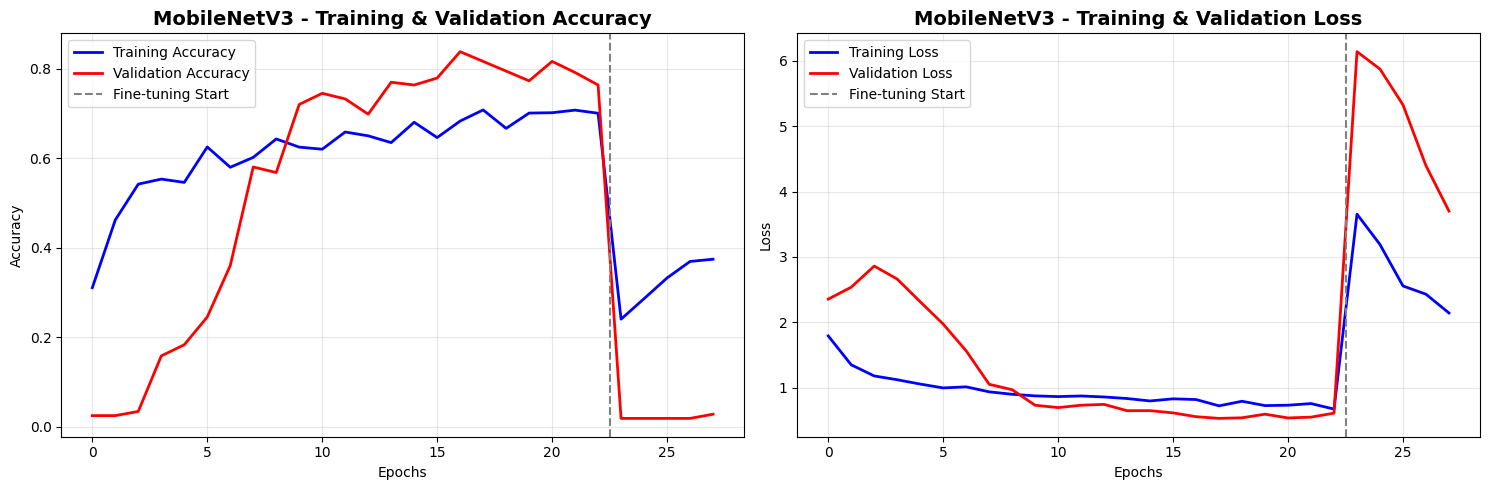


Evaluating MobileNetV3 on test set...



MobileNetV3 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.3745
   Final Training Loss:       2.1428
   Final Validation Accuracy: 0.0280
   Final Validation Loss:     3.7024

TEST PHASE:
   Test Accuracy:             0.0217
   Test Loss:                 6.1446

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.0062
   Loss Increase (Val -> Test): +2.4421
   Potential overfitting - consider more regularization
MobileNetV3 model saved as 'saved_models/MobileNetV3_betel_disease.h5'


In [38]:
print("\n" + "="*80)
print("5. TRAINING AND EVALUATING MOBILENET V3")
print("="*80)

# Create MobileNetV3 model
mobilenet_model, mobilenet_base = create_mobilenetv3_model()
print("MobileNetV3 model created successfully!")
print(f"   Total parameters: {mobilenet_model.count_params():,}")

# Define callbacks
mobilenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_MobileNetV3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training MobileNetV3 with frozen base model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=mobilenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(mobilenet_history, "MobileNetV3_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning MobileNetV3...")
mobilenet_base.trainable = True

# Use lower learning rate for fine-tuning
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=mobilenet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=mobilenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(mobilenet_history_fine, "MobileNetV3_phase2")

# Plot training history
plot_training_history(mobilenet_history, mobilenet_history_fine, "MobileNetV3")

# Evaluate on test set
print("\nEvaluating MobileNetV3 on test set...")
mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("MobileNetV3", mobilenet_history, mobilenet_history_fine, mobilenet_test_loss, mobilenet_test_accuracy)

# Store results
all_models_results["MobileNetV3"] = {
    'train_accuracy': mobilenet_history_fine.history['accuracy'][-1],
    'train_loss': mobilenet_history_fine.history['loss'][-1],
    'val_accuracy': mobilenet_history_fine.history['val_accuracy'][-1],
    'val_loss': mobilenet_history_fine.history['val_loss'][-1],
    'test_accuracy': mobilenet_test_accuracy,
    'test_loss': mobilenet_test_loss
}

# Save model
mobilenet_model.save('saved_models/MobileNetV3_betel_disease.h5')
print("MobileNetV3 model saved as 'saved_models/MobileNetV3_betel_disease.h5'")

In [39]:
## Train - DENSENET121 


6. TRAINING AND EVALUATING DENSENET121
DenseNet121 model created successfully!
   Total parameters: 7,572,039

Phase 1: Training DenseNet121 with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4451 - loss: 1.9839
Epoch 1: val_accuracy improved from None to 0.49068, saving model to saved_models/best_DenseNet121.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 411s 5s/step - accuracy: 0.5602 - loss: 1.4698 - val_accuracy: 0.4907 - val_loss: 1.4102 - learning_rate: 5.0000e-04
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7469 - loss: 0.7055
Epoch 2: val_accuracy improved from 0.49068 to 0.78571, saving model to saved_models/best_DenseNet121.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 465s 5s/step - accuracy: 0.7700 - loss: 0.7354 - val_accuracy: 0.7857 - val_loss: 0.6368 - learning_rate: 5.0000e-04
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8077 - loss: 0.4298
Epoch 3: val_accuracy improved from 0.78571 to 0.87267, saving model to saved_models/best_DenseNet121.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 0.8069 - loss: 0.4747 - val_accuracy: 0.8727 - val_loss: 0.3761 - learning_rate: 5.0000e-04
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8343 - loss: 0.3804
Epoch 4: val_accuracy improved from 0.87267 to 0.91925, saving model to saved_models/best_DenseNet121.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.8427 - loss: 0.3514 - val_accuracy: 0.9193 - val_loss: 0.2791 - learning_rate: 5.0000e-04
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8610 - loss: 0.4545
Epoch 5: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.8609 - loss: 0.4176 - val_accuracy: 0.8975 - val_loss: 0.3459 - learning_rate: 5.0000e-04
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8808 - loss: 0.3334
Epoch 6: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.8753 - loss: 0.3329 - val_accuracy: 0.9130 - val_loss: 0.2603 - learning_rate: 5.0000e-04
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8954 - loss: 0.2328
Epoch 7: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 406s 5s/step - accuracy: 0.8819 - loss: 0.2678 - val_accuracy: 0.9161 - val_loss: 0.2480 - learning_rate: 5.0000e-04
Epoch 8/35
81/81 ━━━━━

81/81 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - accuracy: 0.9017 - loss: 0.2485 - val_accuracy: 0.9255 - val_loss: 0.2473 - learning_rate: 5.0000e-04
Epoch 9/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8963 - loss: 0.2068
Epoch 9: val_accuracy improved from 0.92547 to 0.94720, saving model to saved_models/best_DenseNet121.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.9013 - loss: 0.2209 - val_accuracy: 0.9472 - val_loss: 0.2011 - learning_rate: 5.0000e-04
Epoch 10/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9148 - loss: 0.2115
Epoch 10: val_accuracy did not improve from 0.94720
81/81 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9079 - loss: 0.2507 - val_accuracy: 0.9317 - val_loss: 0.2546 - learning_rate: 5.0000e-04
Epoch 11/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9018 - loss: 0.2832
Epoch 11: val_accuracy did not improve from 0.94720
81/81 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - accuracy: 0.8955 - loss: 0.2557 - val_accuracy: 0.9317 - val_loss: 0.2279 - learning_rate: 5.0000e-04
Epoch 12/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8985 - loss: 0.1761
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_accuracy did not improve from 0.94720
81/81 ━━━━━━━━━━━━━━━━━━━━ 392s 4s/step - accuracy: 0.8974 - loss: 0.2089 - val_ac

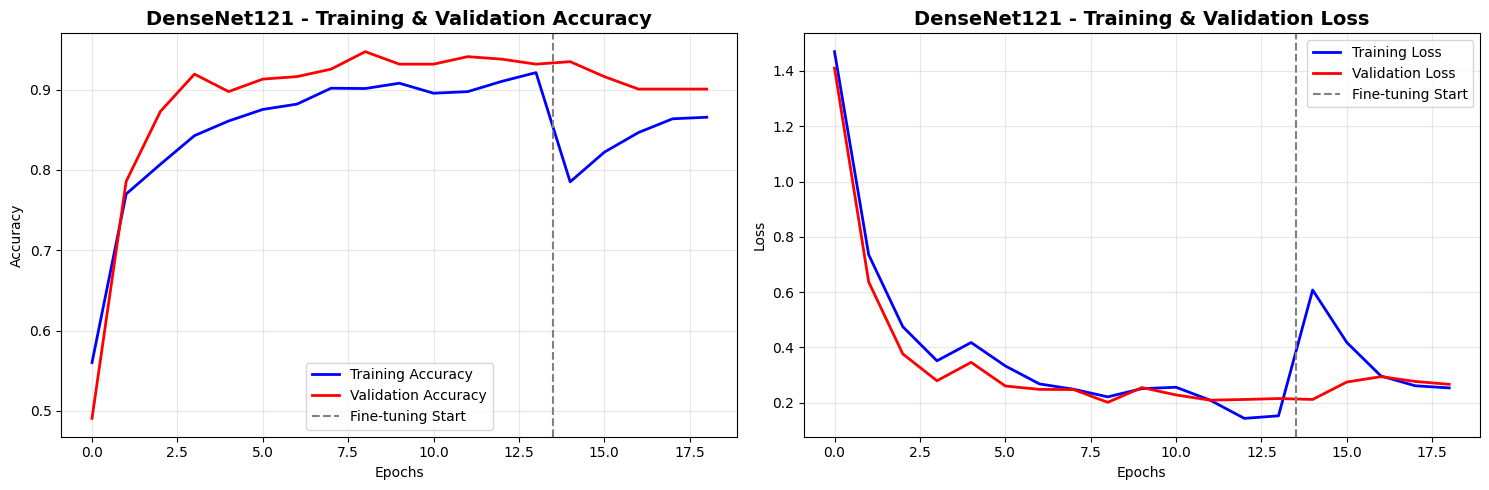


Evaluating DenseNet121 on test set...



DenseNet121 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.8656
   Final Training Loss:       0.2533
   Final Validation Accuracy: 0.9006
   Final Validation Loss:     0.2662

TEST PHASE:
   Test Accuracy:             0.9161
   Test Loss:                 0.2700

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): -0.0155
   Loss Increase (Val -> Test): +0.0037
   Good generalization - model is not overfitting significantly
DenseNet121 model saved as 'saved_models/DenseNet121_betel_disease.h5'


In [40]:
print("\n" + "="*80)
print("6. TRAINING AND EVALUATING DENSENET121")
print("="*80)

# Create DenseNet121 model
densenet_model, densenet_base = create_densenet121_model()
print("DenseNet121 model created successfully!")
print(f"   Total parameters: {densenet_model.count_params():,}")

# Define callbacks
densenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_DenseNet121.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training DenseNet121 with frozen base model...")
densenet_history = densenet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=densenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(densenet_history, "DenseNet121_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning DenseNet121...")
densenet_base.trainable = True

# Use lower learning rate for fine-tuning
densenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

densenet_history_fine = densenet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=densenet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=densenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(densenet_history_fine, "DenseNet121_phase2")

# Plot training history
plot_training_history(densenet_history, densenet_history_fine, "DenseNet121")

# Evaluate on test set
print("\nEvaluating DenseNet121 on test set...")
densenet_test_loss, densenet_test_accuracy = densenet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("DenseNet121", densenet_history, densenet_history_fine, densenet_test_loss, densenet_test_accuracy)

# Store results
all_models_results["DenseNet121"] = {
    'train_accuracy': densenet_history_fine.history['accuracy'][-1],
    'train_loss': densenet_history_fine.history['loss'][-1],
    'val_accuracy': densenet_history_fine.history['val_accuracy'][-1],
    'val_loss': densenet_history_fine.history['val_loss'][-1],
    'test_accuracy': densenet_test_accuracy,
    'test_loss': densenet_test_loss
}

# Save model
densenet_model.save('saved_models/DenseNet121_betel_disease.h5')
print("DenseNet121 model saved as 'saved_models/DenseNet121_betel_disease.h5'")

In [32]:
## Train - GOOGLENET 


7. TRAINING AND EVALUATING INCEPTIONV3
InceptionV3 model created successfully!
   Total parameters: 22,865,703

Phase 1: Training InceptionV3 with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5081 - loss: 1.7556
Epoch 1: val_accuracy improved from None to 0.74534, saving model to saved_models/best_InceptionV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.6049 - loss: 1.3139 - val_accuracy: 0.7453 - val_loss: 0.7795 - learning_rate: 5.0000e-04
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7958 - loss: 0.4766
Epoch 2: val_accuracy improved from 0.74534 to 0.84783, saving model to saved_models/best_InceptionV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7918 - loss: 0.5162 - val_accuracy: 0.8478 - val_loss: 0.4359 - learning_rate: 5.0000e-04
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8521 - loss: 0.2844
Epoch 3: val_accuracy improved from 0.84783 to 0.86335, saving model to saved_models/best_InceptionV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8520 - loss: 0.2892 - val_accuracy: 0.8634 - val_loss: 0.3882 - learning_rate: 5.0000e-04
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8454 - loss: 0.3895
Epoch 4: val_accuracy improved from 0.86335 to 0.91925, saving model to saved_models/best_InceptionV3.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.8586 - loss: 0.3410 - val_accuracy: 0.9193 - val_loss: 0.2788 - learning_rate: 5.0000e-04
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8878 - loss: 0.2372
Epoch 5: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.8792 - loss: 0.2326 - val_accuracy: 0.8913 - val_loss: 0.3438 - learning_rate: 5.0000e-04
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8968 - loss: 0.1965
Epoch 6: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.8951 - loss: 0.1989 - val_accuracy: 0.8696 - val_loss: 0.3886 - learning_rate: 5.0000e-04
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9053 - loss: 0.1835
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: val_accuracy did not improve from 0.91925
81/81 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.9017 - loss: 0.1825 - val_accuracy:

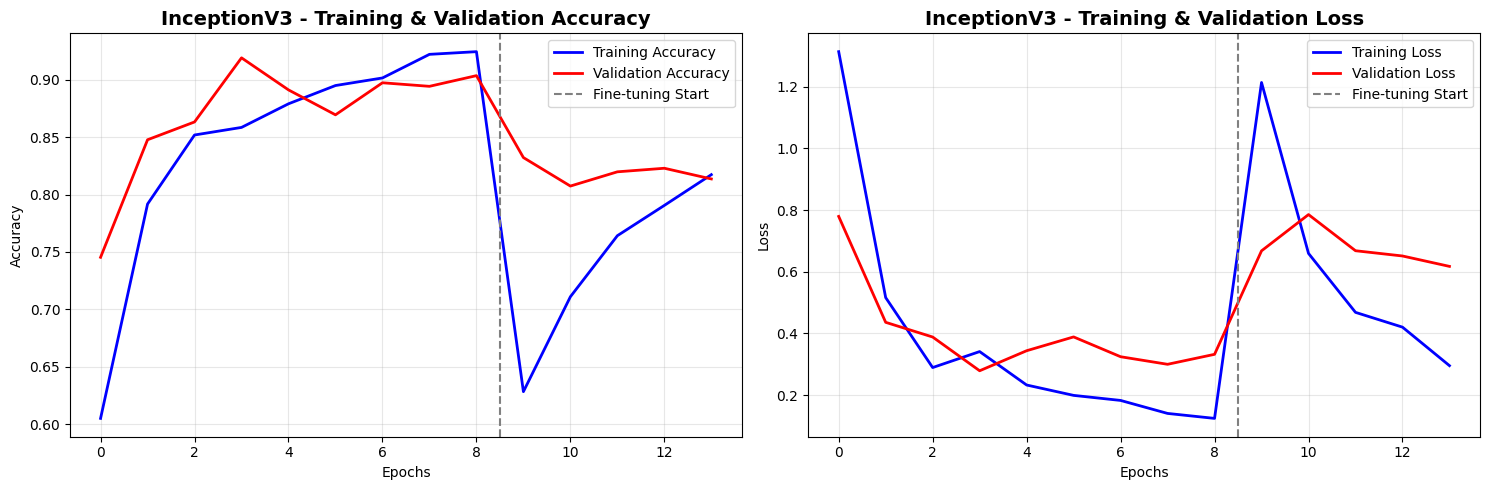


Evaluating InceptionV3 on test set...



InceptionV3 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.8174
   Final Training Loss:       0.2954
   Final Validation Accuracy: 0.8137
   Final Validation Loss:     0.6174

TEST PHASE:
   Test Accuracy:             0.8292
   Test Loss:                 0.6434

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): -0.0155
   Loss Increase (Val -> Test): +0.0260
   Good generalization - model is not overfitting significantly
InceptionV3 model saved as 'saved_models/InceptionV3_betel_disease.h5'


In [33]:
print("\n" + "="*80)
print("7. TRAINING AND EVALUATING INCEPTIONV3")
print("="*80)

# Create InceptionV3 model
inception_model, inception_base = create_googlenet_model()
print("InceptionV3 model created successfully!")
print(f"   Total parameters: {inception_model.count_params():,}")

# Define callbacks
inception_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_InceptionV3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training InceptionV3 with frozen base model...")
inception_history = inception_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=inception_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(inception_history, "InceptionV3_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning InceptionV3...")
inception_base.trainable = True

# Use lower learning rate for fine-tuning
inception_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

inception_history_fine = inception_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=inception_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=inception_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(inception_history_fine, "InceptionV3_phase2")

# Plot training history
plot_training_history(inception_history, inception_history_fine, "InceptionV3")

# Evaluate on test set
print("\nEvaluating InceptionV3 on test set...")
inception_test_loss, inception_test_accuracy = inception_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("InceptionV3", inception_history, inception_history_fine, inception_test_loss, inception_test_accuracy)

# Store results
all_models_results["InceptionV3"] = {
    'train_accuracy': inception_history_fine.history['accuracy'][-1],
    'train_loss': inception_history_fine.history['loss'][-1],
    'val_accuracy': inception_history_fine.history['val_accuracy'][-1],
    'val_loss': inception_history_fine.history['val_loss'][-1],
    'test_accuracy': inception_test_accuracy,
    'test_loss': inception_test_loss
}

# Save model
inception_model.save('saved_models/InceptionV3_betel_disease.h5')
print("InceptionV3 model saved as 'saved_models/InceptionV3_betel_disease.h5'")

In [19]:
## Train - CONVNEXT 

In [ ]:
print("\n" + "="*80)
print("3. TRAINING AND EVALUATING CONVNEXT")
print("="*80)

# Create ConvNeXt model
convnext_model, convnext_base = create_convnext_model()
print("ConvNeXt model created successfully!")
print(f"   Total parameters: {convnext_model.count_params():,}")

# Define callbacks
convnext_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_ConvNeXt.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training ConvNeXt with frozen base model...")
convnext_history = convnext_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=convnext_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(convnext_history, "ConvNeXt_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning ConvNeXt...")
convnext_base.trainable = True

# Use lower learning rate for fine-tuning
convnext_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

convnext_history_fine = convnext_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=convnext_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=convnext_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(convnext_history_fine, "ConvNeXt_phase2")

# Plot training history
plot_training_history(convnext_history, convnext_history_fine, "ConvNeXt")

# Evaluate on test set
print("\nEvaluating ConvNeXt on test set...")
convnext_test_loss, convnext_test_accuracy = convnext_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("ConvNeXt", convnext_history, convnext_history_fine, convnext_test_loss, convnext_test_accuracy)

# Store results
all_models_results["ConvNeXt"] = {
    'train_accuracy': convnext_history_fine.history['accuracy'][-1],
    'train_loss': convnext_history_fine.history['loss'][-1],
    'val_accuracy': convnext_history_fine.history['val_accuracy'][-1],
    'val_loss': convnext_history_fine.history['val_loss'][-1],
    'test_accuracy': convnext_test_accuracy,
    'test_loss': convnext_test_loss
}

# Save model
convnext_model.save('saved_models/ConvNeXt_betel_disease.h5')
print("ConvNeXt model saved as 'saved_models/ConvNeXt_betel_disease.h5'")


3. TRAINING AND EVALUATING CONVNEXT

ConvNeXt model created successfully!
   Total parameters: 49,857,127

Phase 1: Training ConvNeXt with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.2933 - loss: 2.4190 
Epoch 1: val_accuracy improved from None to 0.40557, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2826s 34s/step - accuracy: 0.3739 - loss: 2.0195 - val_accuracy: 0.4056 - val_loss: 1.5781 - learning_rate: 0.0010
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.5791 - loss: 1.1073 
Epoch 2: val_accuracy improved from 0.40557 to 0.61610, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2746s 34s/step - accuracy: 0.5909 - loss: 1.0915 - val_accuracy: 0.6161 - val_loss: 1.2868 - learning_rate: 0.0010
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.6697 - loss: 0.8219 
Epoch 3: val_accuracy improved from 0.61610 to 0.66563, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2683s 33s/step - accuracy: 0.6711 - loss: 0.8542 - val_accuracy: 0.6656 - val_loss: 1.1165 - learning_rate: 0.0010
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7049 - loss: 0.7674 
Epoch 4: val_accuracy improved from 0.66563 to 0.77399, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2739s 34s/step - accuracy: 0.7090 - loss: 0.8189 - val_accuracy: 0.7740 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - accuracy: 0.7107 - loss: 0.6989 
Epoch 5: val_accuracy improved from 0.77399 to 0.82043, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 4692s 58s/step - accuracy: 0.7218 - loss: 0.7302 - val_accuracy: 0.8204 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7153 - loss: 0.6512 
Epoch 6: val_accuracy did not improve from 0.82043
81/81 ━━━━━━━━━━━━━━━━━━━━ 2343s 29s/step - accuracy: 0.7191 - loss: 0.6859 - val_accuracy: 0.8111 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7488 - loss: 0.6995 
Epoch 7: val_accuracy improved from 0.82043 to 0.83591, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2351s 29s/step - accuracy: 0.7555 - loss: 0.6543 - val_accuracy: 0.8359 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 8/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7755 - loss: 0.6510 
Epoch 8: val_accuracy did not improve from 0.83591
81/81 ━━━━━━━━━━━━━━━━━━━━ 2347s 29s/step - accuracy: 0.7772 - loss: 0.5991 - val_accuracy: 0.8235 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 9/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7736 - loss: 0.6153 
Epoch 9: val_accuracy did not improve from 0.83591
81/81 ━━━━━━━━━━━━━━━━━━━━ 2339s 28s/step - accuracy: 0.7826 - loss: 0.5499 - val_accuracy: 0.8235 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 10/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.7786 - loss: 0.5236 
Epoch 10: val_accuracy did not improve from 0.83591
81/81 ━━━━━━━━━━━━━━━━━━━━ 2705s 33s/step - accuracy: 0.7761 - loss: 0.5211 - val_accuracy: 0.8359 - val_loss: 0.4443 - learning_rate: 0.0010
Epoch 11/35
81/81 ━━━━

81/81 ━━━━━━━━━━━━━━━━━━━━ 24840s 310s/step - accuracy: 0.8102 - loss: 0.4764 - val_accuracy: 0.8452 - val_loss: 0.4422 - learning_rate: 5.0000e-04
Epoch 15/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8211 - loss: 0.4145 
Epoch 15: val_accuracy improved from 0.84520 to 0.86997, saving model to saved_models/best_ConvNeXt.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2371s 29s/step - accuracy: 0.8233 - loss: 0.4286 - val_accuracy: 0.8700 - val_loss: 0.3797 - learning_rate: 5.0000e-04
Epoch 16/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8210 - loss: 0.3958 
Epoch 16: val_accuracy did not improve from 0.86997
81/81 ━━━━━━━━━━━━━━━━━━━━ 2444s 30s/step - accuracy: 0.8191 - loss: 0.4216 - val_accuracy: 0.8359 - val_loss: 0.4493 - learning_rate: 5.0000e-04
Epoch 17/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8203 - loss: 0.4512 
Epoch 17: val_accuracy did not improve from 0.86997
81/81 ━━━━━━━━━━━━━━━━━━━━ 2374s 29s/step - accuracy: 0.8276 - loss: 0.3941 - val_accuracy: 0.8669 - val_loss: 0.3459 - learning_rate: 5.0000e-04
Epoch 18/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8311 - loss: 0.4611 
Epoch 18: val_accuracy did not improve from 0.86997
81/81 ━━━━━━━━━━━━━━━━━━━━ 2389s 29s/step - accuracy: 0.8318 - loss: 0.4311 - val_accuracy: 0.8483 - val_loss: 0.4008 - learning_rate: 5.0000e-04
Ep

In [32]:
## Train - VGG 16

In [ ]:
print("\n" + "="*80)
print("7. TRAINING AND EVALUATING VGG16")
print("="*80)

# Create VGG16 model
vgg16_model, vgg16_base = create_vgg16_model()
print("VGG16 model created successfully!")
print(f"   Total parameters: {vgg16_model.count_params():,}")

# Define callbacks
vgg16_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_VGG16.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training VGG16 with frozen base model...")
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=vgg16_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(vgg16_history, "VGG16_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning VGG16...")
vgg16_base.trainable = True

# Fine-tune from later blocks (keep early layers frozen)
for layer in vgg16_base.layers[:15]:  # Freeze first 15 layers
    layer.trainable = False

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001/10),  # Very low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

vgg16_history_fine = vgg16_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=vgg16_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=vgg16_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(vgg16_history_fine, "VGG16_phase2")

# Plot training history
plot_training_history(vgg16_history, vgg16_history_fine, "VGG16")

# Evaluate on test set
print("\nEvaluating VGG16 on test set...")
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("VGG16", vgg16_history, vgg16_history_fine, vgg16_test_loss, vgg16_test_accuracy)

# Store results
all_models_results["VGG16"] = {
    'train_accuracy': vgg16_history_fine.history['accuracy'][-1],
    'train_loss': vgg16_history_fine.history['loss'][-1],
    'val_accuracy': vgg16_history_fine.history['val_accuracy'][-1],
    'val_loss': vgg16_history_fine.history['val_loss'][-1],
    'test_accuracy': vgg16_test_accuracy,
    'test_loss': vgg16_test_loss
}

# Save model
vgg16_model.save('saved_models/VGG16_betel_disease.h5')
print("VGG16 model saved as 'saved_models/VGG16_betel_disease.h5'")


7. TRAINING AND EVALUATING VGG16
VGG16 model created successfully!
   Total parameters: 14,985,031

Phase 1: Training VGG16 with frozen base model...
Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1532 - loss: 3.0587 
Epoch 1: val_accuracy improved from None to 0.28793, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1076s 13s/step - accuracy: 0.2034 - loss: 2.7573 - val_accuracy: 0.2879 - val_loss: 1.9334 - learning_rate: 1.0000e-04
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2835 - loss: 1.9841 
Epoch 2: val_accuracy improved from 0.28793 to 0.55418, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 991s 12s/step - accuracy: 0.3092 - loss: 1.9189 - val_accuracy: 0.5542 - val_loss: 1.5978 - learning_rate: 1.0000e-04
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3829 - loss: 1.8746 
Epoch 3: val_accuracy improved from 0.55418 to 0.65635, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1119s 13s/step - accuracy: 0.3828 - loss: 1.7277 - val_accuracy: 0.6563 - val_loss: 1.3060 - learning_rate: 1.0000e-04
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4149 - loss: 1.5388 
Epoch 4: val_accuracy improved from 0.65635 to 0.66873, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1071s 13s/step - accuracy: 0.4212 - loss: 1.5433 - val_accuracy: 0.6687 - val_loss: 1.0888 - learning_rate: 1.0000e-04
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4332 - loss: 1.4567 
Epoch 5: val_accuracy improved from 0.66873 to 0.68421, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 999s 12s/step - accuracy: 0.4564 - loss: 1.4742 - val_accuracy: 0.6842 - val_loss: 0.9521 - learning_rate: 1.0000e-04
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5031 - loss: 1.3807 
Epoch 6: val_accuracy improved from 0.68421 to 0.72446, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1072s 12s/step - accuracy: 0.4994 - loss: 1.3996 - val_accuracy: 0.7245 - val_loss: 0.8341 - learning_rate: 1.0000e-04
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5198 - loss: 1.2892 
Epoch 7: val_accuracy improved from 0.72446 to 0.74303, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1046s 13s/step - accuracy: 0.5203 - loss: 1.2862 - val_accuracy: 0.7430 - val_loss: 0.7461 - learning_rate: 1.0000e-04
Epoch 8/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5260 - loss: 1.1451 
Epoch 8: val_accuracy improved from 0.74303 to 0.78019, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1037s 13s/step - accuracy: 0.5463 - loss: 1.1236 - val_accuracy: 0.7802 - val_loss: 0.6729 - learning_rate: 1.0000e-04
Epoch 9/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5611 - loss: 1.1443 
Epoch 9: val_accuracy improved from 0.78019 to 0.80495, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1044s 13s/step - accuracy: 0.5591 - loss: 1.1614 - val_accuracy: 0.8050 - val_loss: 0.5987 - learning_rate: 1.0000e-04
Epoch 10/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5905 - loss: 1.0115 
Epoch 10: val_accuracy did not improve from 0.80495
81/81 ━━━━━━━━━━━━━━━━━━━━ 1059s 13s/step - accuracy: 0.5971 - loss: 1.0639 - val_accuracy: 0.8019 - val_loss: 0.5587 - learning_rate: 1.0000e-04
Epoch 11/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6313 - loss: 0.9572 
Epoch 11: val_accuracy improved from 0.80495 to 0.82353, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1202s 15s/step - accuracy: 0.6203 - loss: 1.0025 - val_accuracy: 0.8235 - val_loss: 0.5289 - learning_rate: 1.0000e-04
Epoch 12/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6481 - loss: 0.7453 
Epoch 12: val_accuracy improved from 0.82353 to 0.84211, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1263s 15s/step - accuracy: 0.6312 - loss: 0.8515 - val_accuracy: 0.8421 - val_loss: 0.4933 - learning_rate: 1.0000e-04
Epoch 13/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6331 - loss: 0.9249 
Epoch 13: val_accuracy did not improve from 0.84211
81/81 ━━━━━━━━━━━━━━━━━━━━ 1280s 15s/step - accuracy: 0.6404 - loss: 0.9167 - val_accuracy: 0.8421 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 14/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6552 - loss: 0.8178 
Epoch 14: val_accuracy improved from 0.84211 to 0.85449, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1287s 15s/step - accuracy: 0.6490 - loss: 0.9189 - val_accuracy: 0.8545 - val_loss: 0.4548 - learning_rate: 1.0000e-04
Epoch 15/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6610 - loss: 0.9264 
Epoch 15: val_accuracy improved from 0.85449 to 0.85759, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1239s 15s/step - accuracy: 0.6548 - loss: 0.9314 - val_accuracy: 0.8576 - val_loss: 0.4353 - learning_rate: 1.0000e-04
Epoch 16/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6643 - loss: 0.7828 
Epoch 16: val_accuracy improved from 0.85759 to 0.86997, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1281s 15s/step - accuracy: 0.6753 - loss: 0.7596 - val_accuracy: 0.8700 - val_loss: 0.4178 - learning_rate: 1.0000e-04
Epoch 17/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6774 - loss: 0.8749 
Epoch 17: val_accuracy improved from 0.86997 to 0.87616, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1284s 15s/step - accuracy: 0.6835 - loss: 0.8365 - val_accuracy: 0.8762 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 18/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7145 - loss: 0.6785 
Epoch 18: val_accuracy improved from 0.87616 to 0.88235, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1283s 15s/step - accuracy: 0.7055 - loss: 0.7094 - val_accuracy: 0.8824 - val_loss: 0.3924 - learning_rate: 1.0000e-04
Epoch 19/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7113 - loss: 0.9221 
Epoch 19: val_accuracy did not improve from 0.88235
81/81 ━━━━━━━━━━━━━━━━━━━━ 1285s 15s/step - accuracy: 0.6943 - loss: 0.8469 - val_accuracy: 0.8824 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 20/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7105 - loss: 0.6905 
Epoch 20: val_accuracy improved from 0.88235 to 0.88545, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1246s 15s/step - accuracy: 0.6974 - loss: 0.7691 - val_accuracy: 0.8854 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 21/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7009 - loss: 0.8052 
Epoch 21: val_accuracy did not improve from 0.88545
81/81 ━━━━━━━━━━━━━━━━━━━━ 1243s 15s/step - accuracy: 0.7191 - loss: 0.7132 - val_accuracy: 0.8824 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 22/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7357 - loss: 0.6521 
Epoch 22: val_accuracy improved from 0.88545 to 0.88854, saving model to saved_models/best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1245s 15s/step - accuracy: 0.7218 - loss: 0.7128 - val_accuracy: 0.8885 - val_loss: 0.3417 - learning_rate: 1.0000e-04
Epoch 23/35


In [ ]:
#### Load model and training history

In [4]:
import pandas as pd
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [28]:
# Extract full test images and labels from your tf.data.Dataset
test_images = []
test_labels = []

for img_batch, lbl_batch in test_dataset:
    test_images.append(img_batch.numpy())
    test_labels.append(lbl_batch.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print(f"Test data ready → Images: {test_images.shape}, Labels: {test_labels.shape}")
print(f"Label type: {test_labels.dtype} | Sample labels: {test_labels[:10]}")

Test data ready → Images: (323, 224, 224, 3), Labels: (323,)
Label type: int64 | Sample labels: [5 1 5 1 5 1 5 5 5 1]


In [5]:
%matplotlib inline
plt.style.use('default')
sns.set_style("whitegrid")

In [29]:
def load_model_and_history(model_path, history_path):
    try:
        model = keras.models.load_model(model_path)
        print(f"Loaded model: {os.path.basename(model_path)}")
    except Exception as e:
        print(f"Failed model {model_path}: {e}")
        return None, None

    history = {}
    if os.path.exists(history_path):
        try:
            with open(history_path, 'rb') as f:
                hist_data = pickle.load(f)
                
                if isinstance(hist_data, dict):
                    history = hist_data
                else:
                    history = {k: v for k, v in hist_data.history.items()}
            print(f"Loaded history: {os.path.basename(history_path)}")
        except:
            print(f"Could not load history: {history_path}")
    return model, history


def evaluate_model(model, X_test, y_test_sparse):
    preds = model.predict(X_test, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = y_test_sparse

    
    test_loss, test_acc_from_model = model.evaluate(X_test, y_test_sparse, verbose=0)

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'test_loss': test_loss,
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'predicted_classes': y_pred,
        'true_classes': y_true
    }


def run_comparison(model_configs, class_names=CLASS_NAMES):
    results = []
    print("MODEL COMPARISON STARTED\n" + "="*90)

    for i, (model_path, history_path) in enumerate(model_configs, 1):
        print(f"\n[{i}/{len(model_configs)}] Evaluating {os.path.basename(model_path)}")

        model, history = load_model_and_history(model_path, history_path)
        if model is None:
            continue

        metrics = evaluate_model(model, test_images, test_labels)
        model_name = os.path.basename(model_path).replace('.h5', '').replace('.keras', '')

        print(f"  Test Accuracy: {metrics['accuracy']:.4f} | Macro F1: {metrics['macro_f1']:.4f}")

        results.append({
            'model_name': model_name,
            'history': history,
            **metrics
        })

    if not results:
        print("No models loaded!")
        return None, None

    # Comparison Table
    table = []
    for r in results:
        h = r['history']
        train_acc = h.get('accuracy', [0])[-1] if h else None
        val_acc = h.get('val_accuracy', [0])[-1] if h else None

        table.append({
            'Model': r['model_name'],
            'Test Acc': f"{r['accuracy']:.4f}",
            'Macro F1': f"{r['macro_f1']:.4f}",
            'Weighted F1': f"{r['weighted_f1']:.4f}",
            'Train Acc': f"{train_acc:.4f}" if train_acc else "-",
            'Val Acc': f"{val_acc:.4f}" if val_acc else "-",
        })

    df = pd.DataFrame(table)
    print("\n" + "="*100)
    print("FINAL RESULTS TABLE")
    print("="*100)
    print(df.to_string(index=False))

    # Best model
    best = max(results, key=lambda x: x['accuracy'])
    print(f"\nBEST MODEL → {best['model_name']}")
    print(f"   Test Accuracy : {best['accuracy']:.4f}")
    print(f"   Macro F1      : {best['macro_f1']:.4f}")

    # Plots
    fig = plt.figure(figsize=(18, 12))

    # Accuracy curves
    plt.subplot(2, 3, 1)
    for r in results:
        h = r['history']
        if h and 'accuracy' in h:
            plt.plot(h['accuracy'], label=f"{r['model_name']} Train")
            if 'val_accuracy' in h:
                plt.plot(h['val_accuracy'], '--', label=f"{r['model_name']} Val")
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Loss curves
    plt.subplot(2, 3, 2)
    for r in results:
        h = r['history']
        if h and 'loss' in h:
            plt.plot(h['loss'], label=f"{r['model_name']} Train")
            if 'val_loss' in h:
                plt.plot(h['val_loss'], '--', label=f"{r['model_name']} Val")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Test Accuracy Bar
    plt.subplot(2, 3, 3)
    names = [r['model_name'] for r in results]
    accs = [r['accuracy'] for r in results]
    bars = plt.bar(names, accs, color=['#4e79a7','#f28e2b','#e15759','#76b7b2','#59a14f'][:len(names)])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{bar.get_height():.4f}", ha='center', va='bottom')

    # Confusion Matrices
    for idx, r in enumerate(results):
        plt.subplot(2, len(results), len(results) + 1 + idx)
        sns.heatmap(r['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"{r['model_name']}")
        plt.xlabel('Pred')
        plt.ylabel('True')

    plt.tight_layout()
    plt.show()

    return results, df

MODEL COMPARISON STARTED

[1/4] Evaluating ResNet50_betel_disease.h5


Loaded model: ResNet50_betel_disease.h5
Loaded history: ResNet50_phase2_history_20251119_184035.pkl
  Test Accuracy: 0.0217 | Macro F1: 0.0061

[2/4] Evaluating MobileNetV3_betel_disease.h5
Failed model saved_models/MobileNetV3_betel_disease.h5: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)

[3/4] Evaluating DenseNet121_betel_disease.h5


Loaded model: DenseNet121_betel_disease.h5
Loaded history: DenseNet121_phase2_history_20251120_000042.pkl
  Test Accuracy: 0.9381 | Macro F1: 0.8577

[4/4] Evaluating InceptionV3_betel_disease.h5


Loaded model: InceptionV3_betel_disease.h5
Loaded history: InceptionV3_phase2_history_20251121_223901.pkl
  Test Accuracy: 0.8638 | Macro F1: 0.7234

FINAL RESULTS TABLE
                    Model Test Acc Macro F1 Weighted F1 Train Acc Val Acc
   ResNet50_betel_disease   0.0217   0.0061      0.0009    0.5983  0.3540
DenseNet121_betel_disease   0.9381   0.8577      0.9392    0.8656  0.9006
InceptionV3_betel_disease   0.8638   0.7234      0.8721    0.8174  0.8137

BEST MODEL → DenseNet121_betel_disease
   Test Accuracy : 0.9381
   Macro F1      : 0.8577


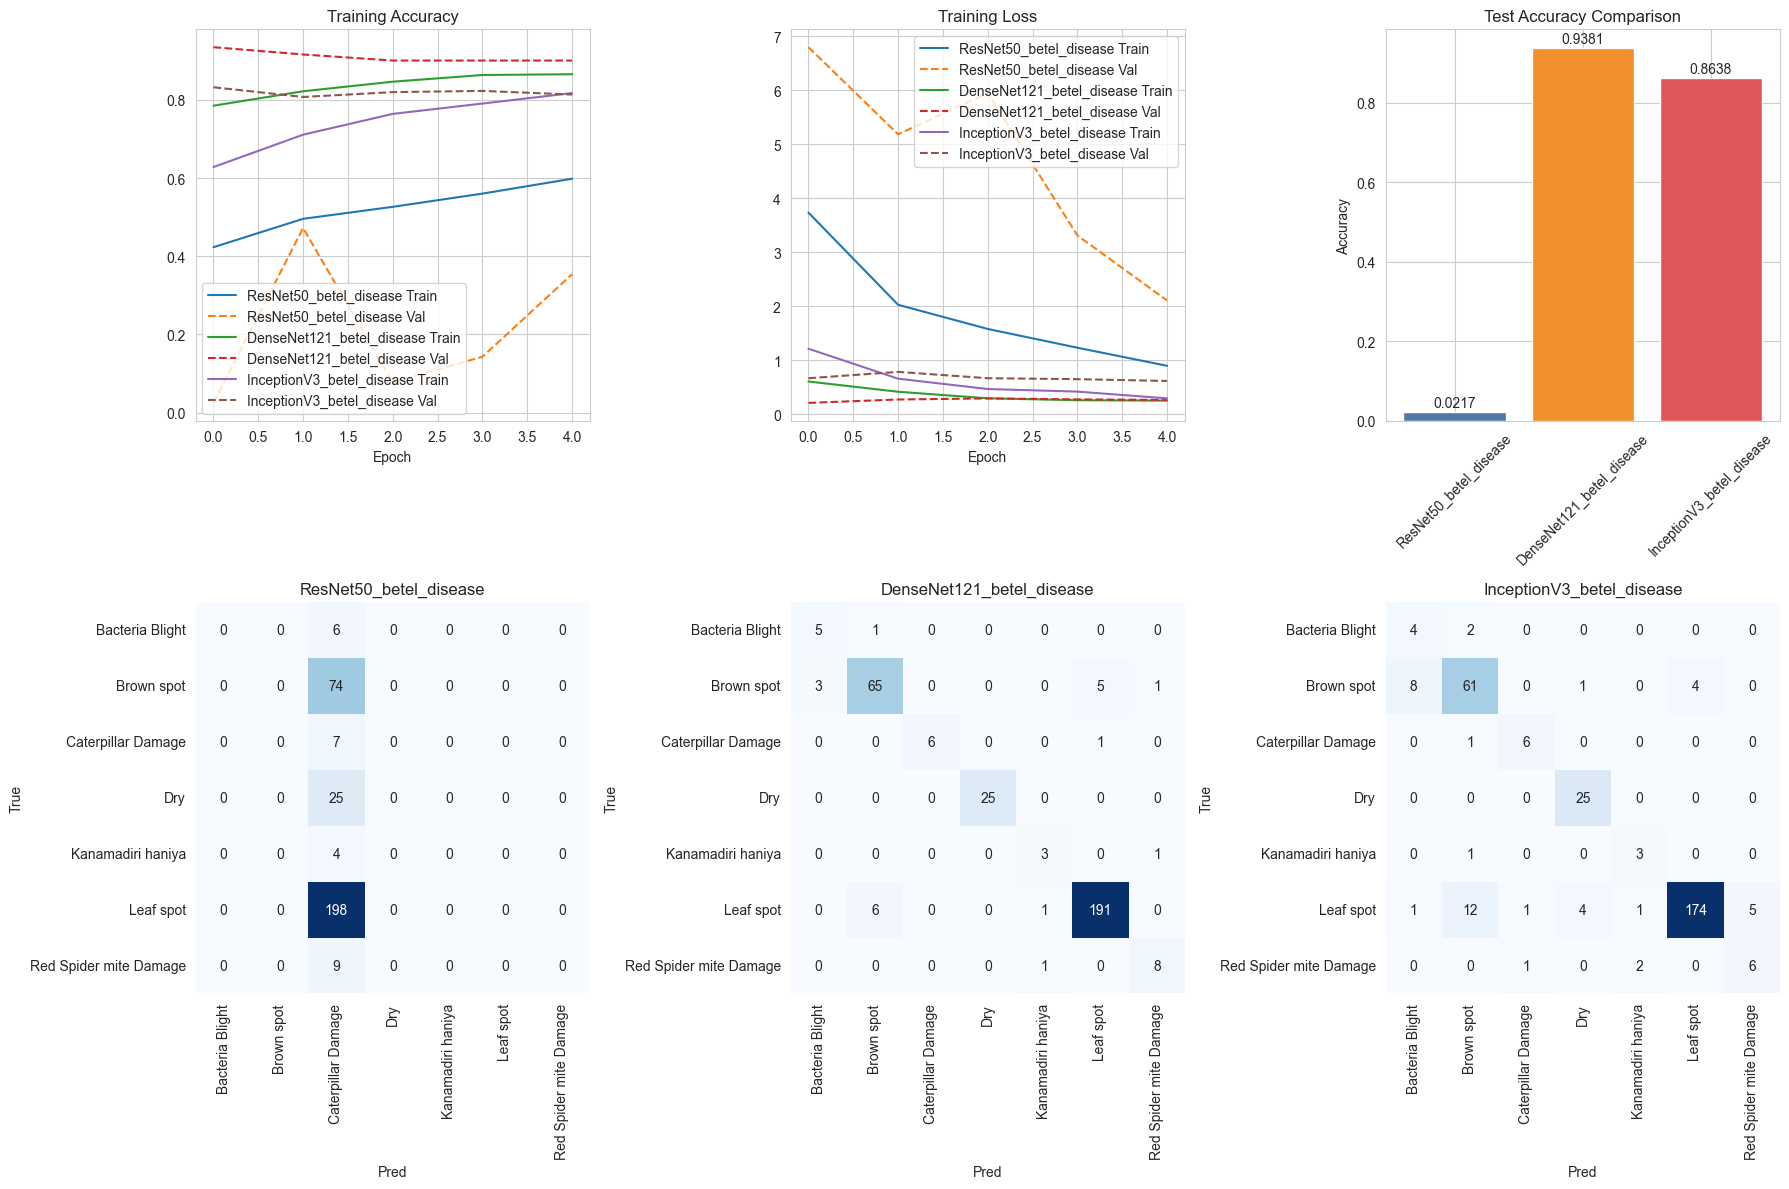

In [30]:
model_configs = [
    ("saved_models/ResNet50_betel_disease.h5",        "training_history/ResNet50_phase2_history_20251119_184035.pkl"),
    ("saved_models/MobileNetV3_betel_disease.h5",     "training_history/MobileNetV3_phase2_history_20251119_201901.pkl"),
    ("saved_models/DenseNet121_betel_disease.h5",     "training_history/DenseNet121_phase2_history_20251120_000042.pkl"),
    ("saved_models/InceptionV3_betel_disease.h5",     "training_history/InceptionV3_phase2_history_20251121_223901.pkl")
]

results, summary_table = run_comparison(model_configs, CLASS_NAMES)